### Цели и описание проекта

**Описание проекта:** Удержание покупательской активности клиентов
Интернет-магазин "В один клик" заметил снижение активности постоянных покупателей. Для решения этой проблемы решено предложить персонализированные предложения с целью удержания клиентов.

**Задача** — разработать модель для прогнозирования снижения активности, используя данные по поведению клиентов на сайте, их покупательскую активность и взаимодействие с маркетинговыми коммуникациями.

**Цель исследования:**
Создать модель, которая предскажет вероятность снижения покупательской активности клиентов, и на основе этих прогнозов выделить сегменты покупателей для персонализированных предложений.

**Ход исследования:**
- Загрузка данных: Изучение четырёх таблиц: market_file.csv, market_money.csv, market_time.csv, и money.csv, содержащих информацию о поведении клиентов, выручке, времени, проведённом на сайте, и прибыли от каждого покупателя.

- Предобработка данных: Проверка данных на корректность, пропуски, дубликаты и приведение типов данных. При необходимости проводится переименование столбцов для удобства анализа.

- Исследовательский анализ данных: Анализ данных о покупательской активности за последние три месяца. Статистический анализ характеристик покупателей и их взаимодействия с сайтом и маркетингом.

- Корреляционный анализ: Оценка взаимосвязи признаков. Выявление мультиколлинеарности, если требуется, с последующим её устранением.

- Создание моделей с использованием пайплайнов:

- Применение пайплайнов для обработки категориальных и количественных данных с использованием различных методов кодирования и масштабирования.
  - Обучение четырёх моделей: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC с подбором гиперпараметров для каждой из них.
  - Выбор наилучшей модели по выбранной метрике (например, F1-score).
  - Анализ важности признаков: Оценка важности признаков для выбранной модели с помощью метода SHAP. Анализ, какие признаки наиболее влияют на снижение активности клиентов.

**Сегментация клиентов:**

- Сегментирование клиентов на основе вероятности снижения активности и их прибыльности.
- Анализ сегментов для разработки персонализированных предложений, направленных на увеличение покупательской активности.

**Выводы:**

- Описание исходной задачи и проведённых этапов: предобработка данных, выбор и обучение модели.
- Рекомендации по дальнейшему использованию сегментации для маркетинговых предложений и повышению активности клиентов.

### Загрузка и изучение данных

In [ ]:
!pip install phik -q
!pip install -U shap matplotlib seaborn -q
!pip install --upgrade scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import sklearn
import shap
import os

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score,  recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
pth = 'https://code.s3.yandex.net/datasets/market_file.csv'

try:
    market_file = pd.read_csv(pth, index_col='id')
except Exception as e:
    print('При чтении файла произошла ошибка:', e)

market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [ ]:
market_file.columns = market_file.columns.str.replace(' ', '_')
market_file.columns

Index(['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [ ]:
pth = 'https://code.s3.yandex.net/datasets/market_money.csv'

try:
    market_money = pd.read_csv(pth, index_col='id')
except Exception as e:
    print('При чтении файла произошла ошибка:', e)

market_money.head()

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6


In [ ]:
pth = 'https://code.s3.yandex.net/datasets/market_time.csv'

try:
    market_time = pd.read_csv(pth, index_col='id')
except Exception as e:
    print('При чтении файла произошла ошибка:', e)

market_time.head()

,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдцщий_месяц,13
215349,текущий_месяц,10
215349,предыдцщий_месяц,12
215350,текущий_месяц,13


In [ ]:
pth = 'https://code.s3.yandex.net/datasets/money.csv'

try:
    money = pd.read_csv(pth, sep=';', decimal=',', index_col='id')
except Exception as e:
    print('При чтении файла произошла ошибка:', e)

money.head()

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


#### Выводы по разделу Загрузка и и изучение данных
- Проведена загрузка данных
- При загру использованы разделители
- Наименование столбцов приведены в змеиный регистр

### Предобработка данных

In [ ]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1300 non-null   object 
 1   Тип_сервиса                          1300 non-null   object 
 2   Разрешить_сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит       

In [ ]:
market_file.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


В market_file преобразование типов не требуется

In [ ]:
cat_columns_market_file = market_file.select_dtypes(include=['object'])
for col in cat_columns_market_file:
  print(col, ':', market_file[col].unique())

Покупательская_активность : ['Снизилась' 'Прежний уровень']
Тип_сервиса : ['премиум' 'стандартт' 'стандарт']
Разрешить_сообщать : ['да' 'нет']
Популярная_категория : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [ ]:
market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт', regex=True)
market_file['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

В market_file исправлены задублированные значения в столбце 'Тип_сервиса'

In [ ]:
market_file.duplicated().sum()

11

В market_file не обнаружены пропуски и дубли

In [ ]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3900 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Период   3900 non-null   object 
 1   Выручка  3900 non-null   float64
dtypes: float64(1), object(1)
memory usage: 91.4+ KB


In [ ]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [ ]:
market_money['Период'].value_counts()

препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1300
Name: Период, dtype: int64

In [ ]:
market_money.duplicated().sum()

746

In [ ]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2600 entries, 215348 to 216647
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Период  2600 non-null   object
 1   минут   2600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.9+ KB


In [ ]:
market_time.duplicated().sum()

2561

In [ ]:
money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


In [ ]:
money.duplicated().sum()

900

#### Вывод по разделу Предобработка данных
- В исходных данных преобразование типов не требуется
- В исходных данных отсутствуют явные и неявные дубликаты
- В исходных данных отсутствуют пропуски
- В market_file исправлены задублированные значения в столбце 'Тип_сервиса'



### Исследовательский анализ данных

In [ ]:
market_file.describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Статистика по признакам в market_file  на адекватна.

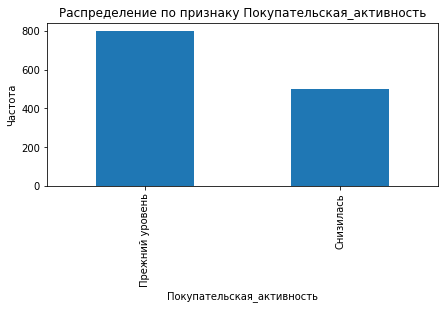

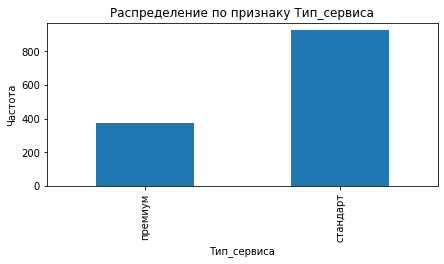

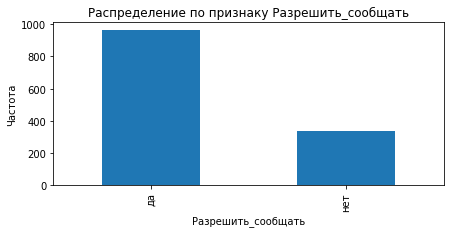

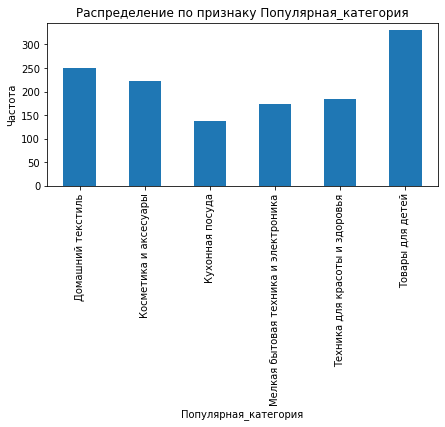

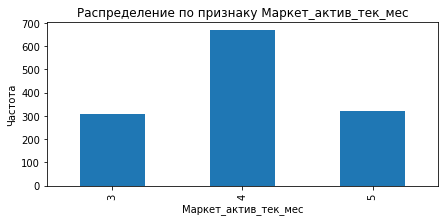

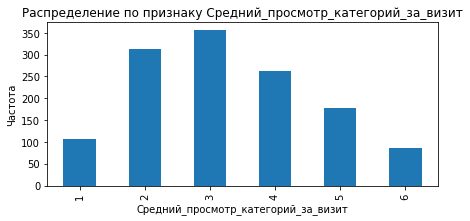

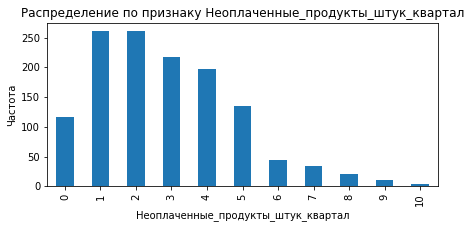

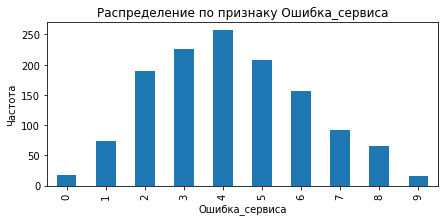

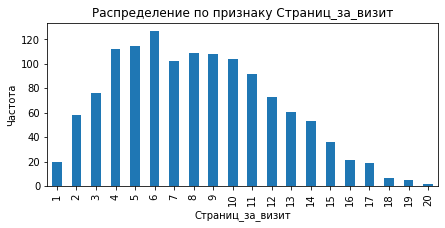

In [ ]:
cat_columns = [
    'Покупательская_активность',
    'Тип_сервиса',
    'Разрешить_сообщать',
    'Популярная_категория',
    'Маркет_актив_тек_мес',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
]

for column in cat_columns:
    market_file.groupby(column)[column].count().plot(kind='bar', figsize=(7,3));
#    sns.countplot(x=column, data=market_file, palette='Set2')
    plt.title('Распределение по признаку '+ column)
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

- покупатели предпочитают товары для детей.
- большинство клиентов разрешили направление предложений по купонам
- ожидаемо большинство клиентов пользуется типом сервисом стандарт

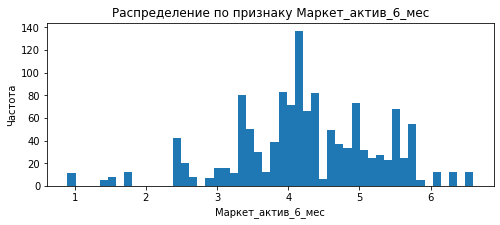

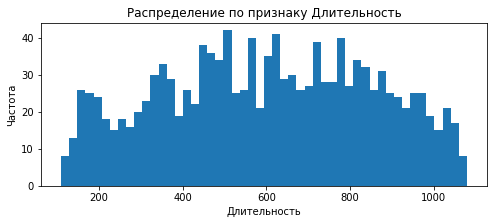

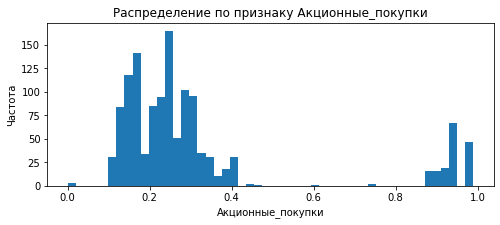

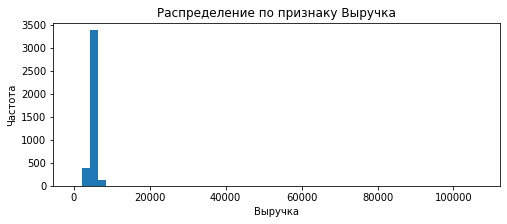

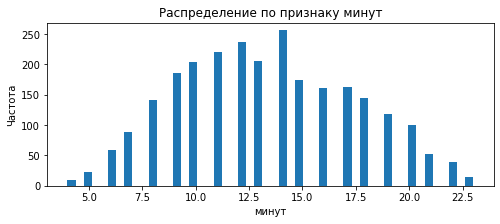

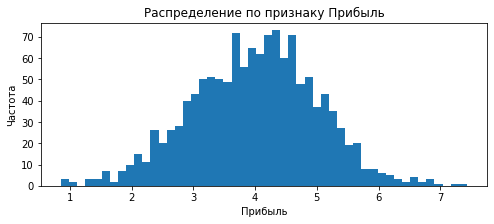

In [ ]:

def show_hist(data, num_columns=None):
    if num_columns is None:
        num_columns = data.select_dtypes(include=['int', 'float'])

    for column in num_columns:
        data[column].plot(kind='hist', bins=50, figsize=(8,3));
        plt.title('Распределение по признаку '+ column)
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()

num_columns = [
    'Маркет_актив_6_мес',
    'Длительность',
    'Акционные_покупки',
]
show_hist(market_file, num_columns)
show_hist(market_money)
show_hist(market_time)
show_hist(money)

- Признак Неоплаченные продукты имеет распредеение Пуассона, а все остальные количественные признаки имеют нормальное распределение.
- Признак акционные покупки имеет выброс, моожно объяснить наличием группы покупателей которые покупают товар только по акции
- По признаку Выручка наблюдаются аномальные значения, Необходимо дополнительно исследовать и принять решение - удалить / не удалить

In [ ]:
market_money[(market_money['Выручка']>20000)]

,Период,Выручка
id,,
215380,текущий_месяц,106862.2


In [ ]:
market_money[(market_money['Выручка']<1000)]

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,предыдущий_месяц,0.0
215357,препредыдущий_месяц,0.0
215357,предыдущий_месяц,0.0
215359,предыдущий_месяц,0.0
215359,препредыдущий_месяц,0.0


In [ ]:
market_money=market_money[(market_money['Выручка']<20000)&(market_money['Выручка']>1000)]

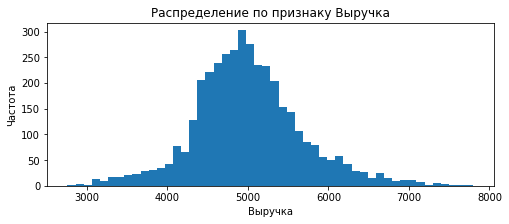

In [ ]:
market_money['Выручка'].plot(kind='hist', bins=50, figsize=(8,3));
plt.title('Распределение по признаку Выручка')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()

Обнаружились покупатели с нулевой выручкой, решил их оставить.

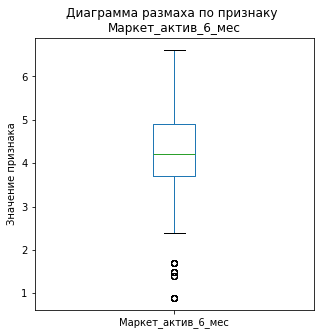

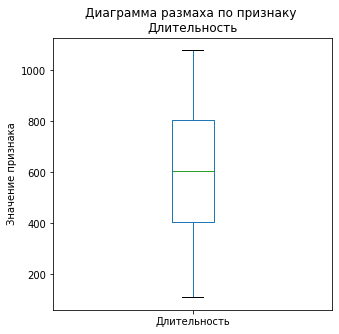

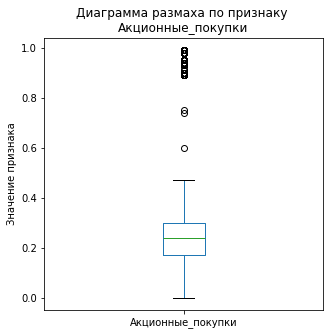

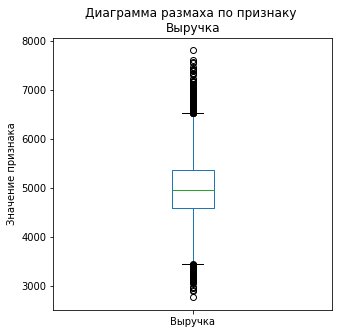

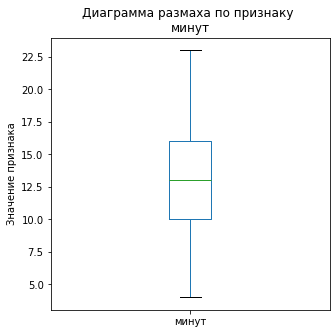

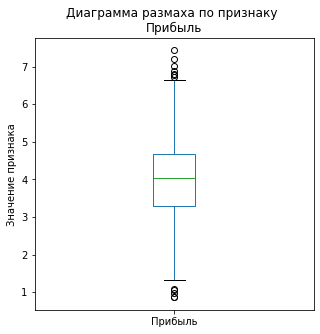

In [ ]:
def show_hist(data, num_columns=None):
    if num_columns is None:
        num_columns = data.select_dtypes(include=['int', 'float'])

    for column in num_columns:
        data[column].plot(kind='box', figsize=(5,5));
        plt.title('Диаграмма размаха по признаку \n'+ column)
        plt.ylabel('Значение признака')
        plt.show()

show_hist(market_file, num_columns)
show_hist(market_money)
show_hist(market_time)
show_hist(money)

По диаграмме размаха признаков Прибыль, Выручка, Неоплаченные продукты, Акционные покупки, Маркет актив наблюдаются выбросы. Принято решение оставить все как есть

#### Выводы по разделу Исследовательский анализ данных
- покупатели предпочитают товары для детей.
- большинство клиентов разрешили направление предложений по купонам
- ожидаемо большинство клиентов пользуется типом сервисом стандарт
- Признак Неоплаченные продукты имеет распредеение Пуассона, а все остальные количественные признаки имеют нормальное распределение.
- Признак акционные покупки имеет выброс, моожно объяснить наличием группы покупателей которые покупают товар только по акции
- По признаку Выручка наблюдаются аномальные значения, принято решение - удалить
- По диаграмме размаха признаков Прибыль, Выручка, Неоплаченные продукты, Акционные покупки, Маркет актив наблюдаются выбросы. Принято решение оставить все как есть

### Объединение таблиц

In [ ]:
market_file.shape

(1300, 12)

In [ ]:
pivoted_market_money = market_money.pivot(columns='Период', values='Выручка')
pivoted_market_money.columns = [ col + '_выручка' for col in pivoted_market_money.columns]
pivoted_market_time = market_time.pivot(columns='Период', values='минут')
pivoted_market_time.columns = [ col + '_мин' for col in pivoted_market_time.columns]

In [ ]:
df = (
    market_file
    .merge(pivoted_market_money, how='left', left_index=True, right_index=True)
    .merge(pivoted_market_time, left_index=True, right_index=True, how='left')
)
df.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдцщий_месяц_мин,текущий_месяц_мин
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [ ]:
df.shape

(1300, 17)

Объединение прошло успешно, количество строк не изменилось.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1300 non-null   object 
 1   Тип_сервиса                          1300 non-null   object 
 2   Разрешить_сообщать                   1300 non-null   object 
 3   Маркет_актив_6_мес                   1300 non-null   float64
 4   Маркет_актив_тек_мес                 1300 non-null   int64  
 5   Длительность                         1300 non-null   int64  
 6   Акционные_покупки                    1300 non-null   float64
 7   Популярная_категория                 1300 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 10  Ошибка_сервиса                       1300 non-null   int64  
 11  Страниц_за_визит       

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1296 non-null   object 
 1   Тип_сервиса                          1296 non-null   object 
 2   Разрешить_сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит       

Обнаружены пропуски принято решение удалить

In [ ]:
df.query('предыдущий_месяц_выручка == 0 or препредыдущий_месяц_выручка == 0 or текущий_месяц_выручка == 0')

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдцщий_месяц_мин,текущий_месяц_мин
id,,,,,,,,,,,,,,,,,


Неактивных пользователей не обнаружео

### Корреляционный анализ признаков

In [ ]:
num_columns = [
    'Маркет_актив_6_мес',
    'Длительность',
    'Акционные_покупки',
    'предыдущий_месяц_выручка',
    'текущий_месяц_выручка',
    'препредыдущий_месяц_выручка',
]

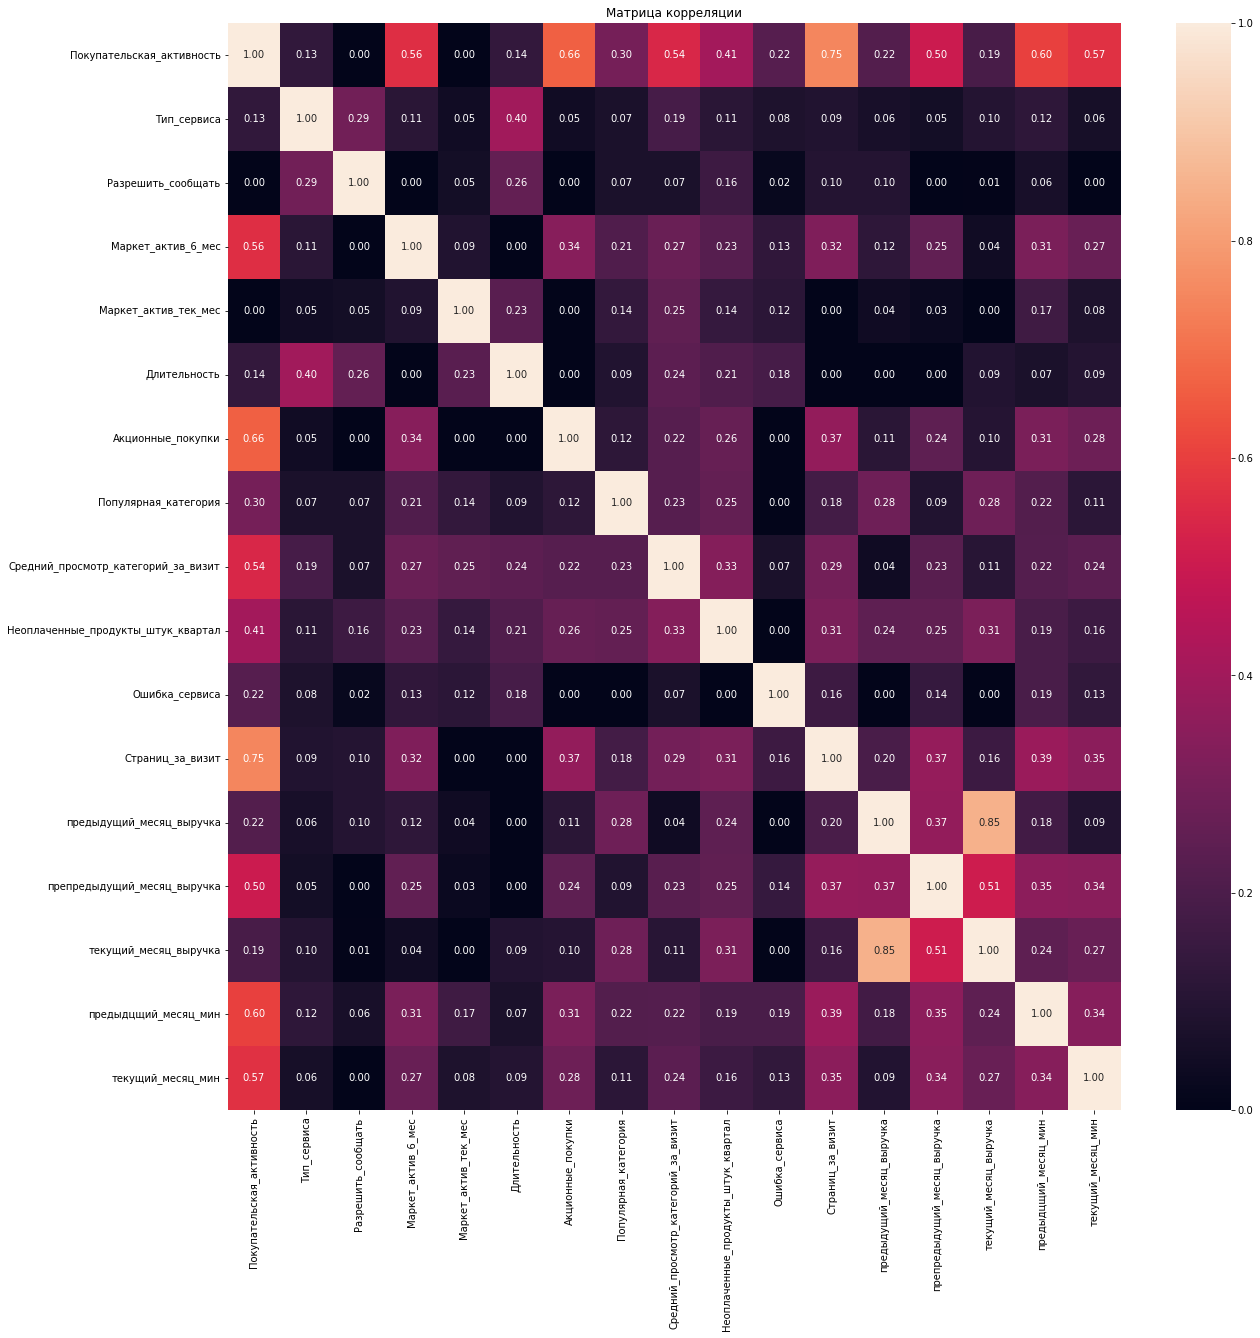

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.phik_matrix(interval_cols=num_columns, bins=20), annot=True, fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

#### Выводы по разделу Корреляционный анализ признаков
- Мульитколлениарных признаков не обнаружено
- Целевой признак Покупательская активность коррелирует с такими признаками как:
  - активность на сайте в предыдущие периоды
  - количество просмотренных страниц за визит
  - неоплаченные товары в корзине
  - средний просмотр категорий за визит
  - акционные покупки
  - среднемесячное значение маркетинговых коммуникаций компании с покупателем

### Использование пайплайнов

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Покупательская_активность'], axis=1),
    df['Покупательская_активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['Покупательская_активность'])

In [ ]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_train = label_encoder.transform(y_train)
category_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(category_mapping)

In [ ]:
category_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(category_mapping)

{0: 'Прежний уровень', 1: 'Снизилась'}


In [ ]:
ohe_columns = [
    'Популярная_категория',
    ]
ord_columns = [
    'Тип_сервиса',
    'Разрешить_сообщать',
    ]
num_columns = [
    'Страниц_за_визит',
    'Ошибка_сервиса',
    'Неоплаченные_продукты_штук_квартал',
    'Средний_просмотр_категорий_за_визит',
    'Акционные_покупки',
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'предыдущий_месяц_выручка',
    'препредыдущий_месяц_выручка',
    'текущий_месяц_выручка',
    'предыдцщий_месяц_мин',
    'текущий_месяц_мин',
    ]

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['нет', 'да'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler() , num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1',
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

]

Принято решение выбрать метрику roc_auc для кросс-валидации так как:
- В количественных признаках наблюдается большое количество выбросов.
- Эта метрика подходит для различных моделей.

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                    

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
9,1,"LogisticRegression(penalty='l1', random_state=...",0.897890,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,2,KNeighborsClassifier(),0.847439,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,3,DecisionTreeClassifier(random_state=42),0.835373,"{'preprocessor__num': 'passthrough', 'models__..."
7,4,DecisionTreeClassifier(random_state=42),0.827998,"{'preprocessor__num': StandardScaler(), 'model..."
1,5,DecisionTreeClassifier(random_state=42),0.816957,"{'preprocessor__num': 'passthrough', 'models__..."
2,6,DecisionTreeClassifier(random_state=42),0.813691,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,7,DecisionTreeClassifier(random_state=42),0.811244,"{'preprocessor__num': 'passthrough', 'models__..."
3,8,DecisionTreeClassifier(random_state=42),0.806342,"{'preprocessor__num': MinMaxScaler(), 'models_..."
0,9,DecisionTreeClassifier(random_state=42),0.794211,"{'preprocessor__num': StandardScaler(), 'model..."
6,10,KNeighborsClassifier(),0.763171,"{'preprocessor__num': 'passthrough', 'models__..."


In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:,1]
y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)
print('roc_auc:', roc_auc)
print('accuracy:', accuracy)
print('f1_score:', f1)

roc_auc: 0.9182138090037616
accuracy: 0.9074074074074074
f1_score: 0.8695652173913043


In [ ]:
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc.fit(X_train, y_train)

dc_predict_proba = dc.predict_proba(X_test)[:, 1]
dc_predict = dc.predict(X_test)

roc_auc = roc_auc_score(y_test, dc_predict_proba)
accuracy = accuracy_score(y_test, dc_predict)
f1 = f1_score(y_test, dc_predict, pos_label=1)
print('roc_auc:', roc_auc)
print('accuracy:', accuracy)
print('f1_score:', f1)

roc_auc: 0.4945394976337823
accuracy: 0.5216049382716049
f1_score: 0.37751004016064255


#### Выводы по разделу Создание пайпланов
- для сравнения выбрана метрика roc_auc, так как сравниваем модели с бинарной классификации и в признаках есть выбросы
- Наилучшей моделю оказалась модел логистической регрессии LogisticRegression(C=1, penalty='l1', random_state=42,                           solver='liblinear') с метрикой 0,9
- на тестовой выборке лучшая модель показала метрику 0,91
- лучшая модель показала мерики лучше чем случайная модель

### Анализ важности признаков

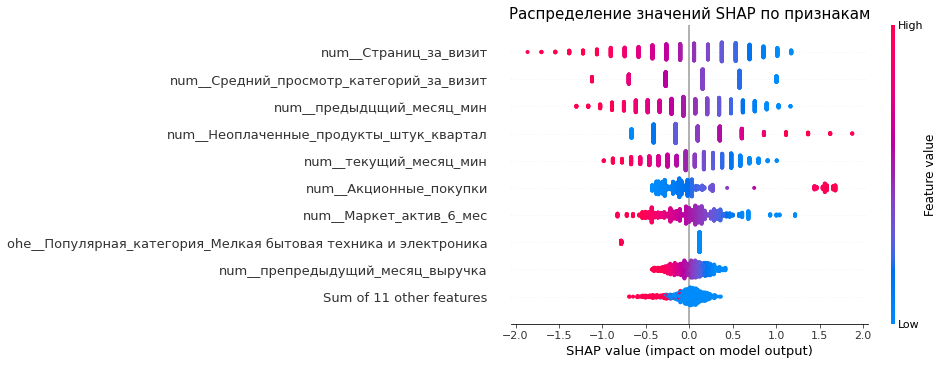

In [ ]:
linear_model = randomized_search.best_estimator_.named_steps['models']

# Применяем пайплайн (все шаги до модели) к обучающим данным
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
new_column_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_column_names)

# Создаем объяснитель для логистической регрессии с уже обработанными данными
explainer = shap.LinearExplainer(linear_model, X_train_transformed)

# Вычисляем SHAP значения для обработанных данных
shap_values = explainer(X_train_transformed)

ax = plt.gca()
ax.set_title("Распределение значений SHAP по признакам" , fontdict={"size":15})

shap.plots.beeswarm(shap_values)

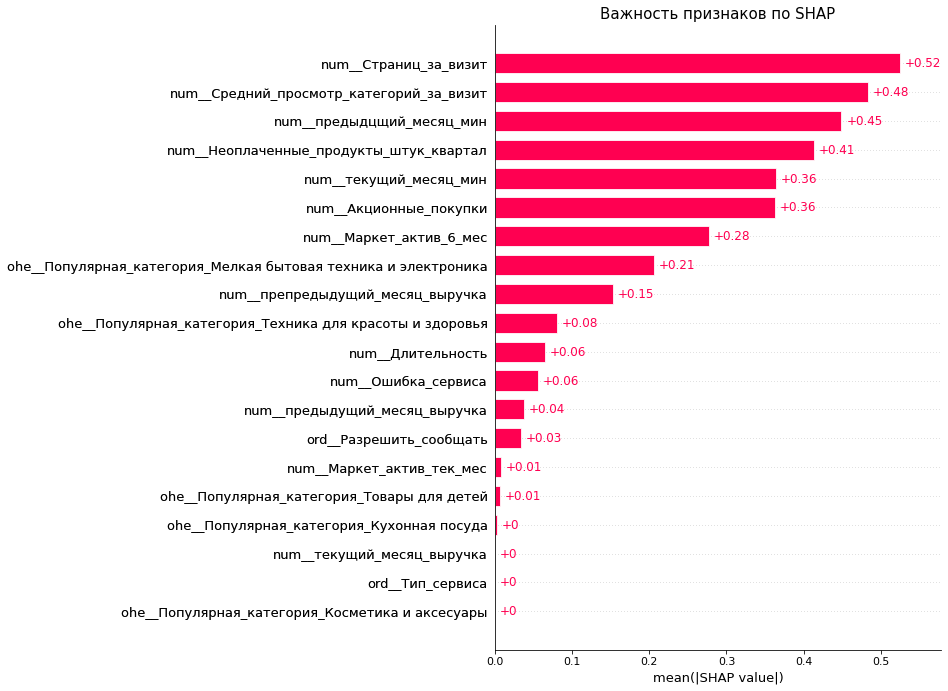

In [ ]:
ax = plt.gca()
ax.set_title('Важность признаков по SHAP', fontdict={"size":15})
shap.plots.bar(shap_values, max_display=shap_values.shape[1])

#### Выводы по разделу:
- Наиболее значимые признаки связаны с поведением покупателя на сайте (Страниц за визит, средний просмотр категорий за визит, время проведенное на сайте, Акционные покупки, неоплаченные продукты)
- Неожиданно наименее значимыммы оказались признаки выручки с покупателя, популярные категории.
- Чем меньше активность на сайте (Страниц за визит, средний просмотр категорий за визит, время проведенное на сайте), тем ниже покупательская активность. Чтобы что-то купить, надо посещать сайт. То есть для повышения покупательской активности необходимо удерживать клиентов на сайте, периодически напоминать о себе. Рекомендации:
  - Регулярные напоминания и вовлечение
  - Стимулирование активности на сайте. Промоакции и скидки
  - Персонализация контента
  - Оптимизация навигации
- Чем выше неоплаченных товаров в корзине, тем ниже покупательская активность. Требуется дополнительная прорботка таких вопросов как:
  - Оптимизация стоимости доставки
  - Разнообразие методов оплаты
  - Упрощение процесса оформления заказа
  - Прозрачность при расчётах, отсутствия скрфтыз платежей
  - возможность гостевой покупки без необходимости регистрации на сайте
- Акционные покупки также влияют на покупательскую активность. Есть группа покупателей покупающая только по акции. Если у покупателя нет других покупок кроме акционных, то высока вероятность снижения покупательской активности. Рекомендации:
  - Индивидуализированные предложения для таких клиентов
  - Программа лояльности, например возможность накапливать баллы за каждую покупку
  



### Сегментация покупателей

In [ ]:
df = X_test.copy()
df = df.merge(money, on='id', how='left')
df['pred_proba'] =  y_pred_proba
df.describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдцщий_месяц_мин,текущий_месяц_мин,Прибыль,pred_proba
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,4.216049,3.962963,590.969136,0.327099,3.330247,2.734568,4.157407,8.145062,4924.632716,4826.731481,5234.353704,13.243827,13.030864,3.907438,0.386104
std,1.048302,0.662006,243.995011,0.254989,1.380608,1.810849,1.986777,4.057704,705.928391,315.802313,815.698162,3.946130,4.373326,0.997418,0.352413
min,0.900000,3.000000,129.000000,0.110000,1.000000,0.000000,0.000000,1.000000,2960.000000,4138.000000,2952.200000,5.000000,4.000000,0.860000,0.003423
25%,3.800000,4.000000,407.000000,0.170000,2.000000,1.000000,3.000000,5.000000,4481.125000,4595.000000,4733.975000,10.000000,10.000000,3.242500,0.084797
50%,4.200000,4.000000,594.500000,0.240000,3.000000,3.000000,4.000000,8.000000,4997.250000,4794.500000,5213.250000,13.000000,13.000000,3.980000,0.211698
75%,4.900000,4.000000,786.000000,0.310000,4.000000,4.000000,6.000000,11.000000,5418.375000,5024.250000,5775.775000,16.000000,16.000000,4.585000,0.762396
max,6.600000,5.000000,1061.000000,0.990000,6.000000,10.000000,9.000000,20.000000,6658.500000,5624.000000,7370.600000,22.000000,23.000000,6.880000,0.996907


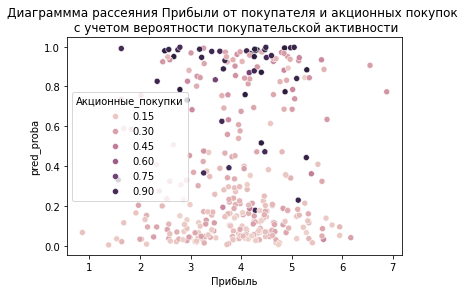

In [ ]:
sns.scatterplot(df, x='Прибыль', y='pred_proba', hue='Акционные_покупки')
plt.title('Диаграммма рассеяния Прибыли от покупателя и акционных покупок \n с учетом вероятности покупательской активности')
plt.show()

Принято решение разбить на 4 сегмента в зависимости от медиан прибыли и вероятности снижения покупательской активности и исследовать каждый из сегментов

In [ ]:
def segment(row):
    proba_median = df['pred_proba'].median()
    profit_median = df['Прибыль'].median()
    if row['pred_proba'] > proba_median:
        if row['Прибыль'] > profit_median:
            return('Прибыльные покупатели с риском снижения покупательской активности')
        else:
            return('Не прибыльные покупатели с риском снижения покупательской активности')
    else:
        if row['Прибыль'] > profit_median:
            return('Прибыльные покупатели без риска снижения покупательской активности')
        else:
            return('Не прибыльные покупатели без риска снижения покупательской активности')
df['segment'] = df.apply(segment, axis=1)

def show_segment(categories, segment):

    for category  in categories:
        df_filter = df.query('segment == @segment')
 #       sns.scatterplot(df_filter, x='Прибыль', y='pred_proba', hue=category)
 #       df.groupby(category)['Прибыль'].sum().plot(kind='bar', figsize=(7,3))

        sns.countplot(x=category, data=df_filter, hue=category, palette='Set2', legend=False);
        plt.title('Распределение по признаку '+ category)
        plt.xlabel(category)
        plt.ylabel('Прибыль')
        plt.show()

        pivot = df_filter.pivot_table(index=category, values='Прибыль', aggfunc='sum')
        total_profit = pivot['Прибыль'].sum()
        pivot['Доля'] = pivot['Прибыль'] / total_profit
        print(pivot)

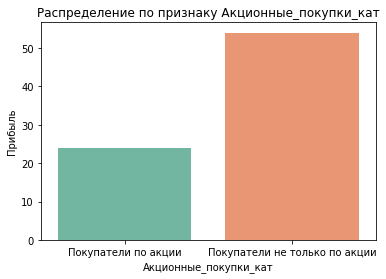

                               Прибыль      Доля
Акционные_покупки_кат                           
Покупатели не только по акции   259.10  0.702301
Покупатели по акции             109.83  0.297699


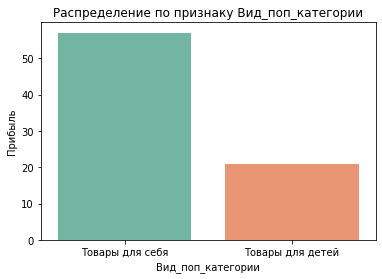

                   Прибыль      Доля
Вид_поп_категории                   
Товары для детей    100.63  0.272762
Товары для себя     268.30  0.727238


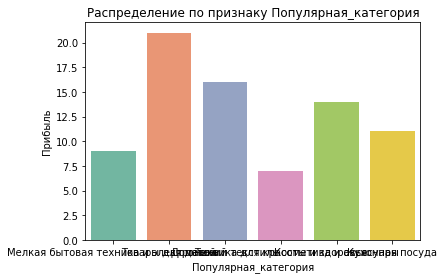

                                      Прибыль      Доля
Популярная_категория                                   
Домашний текстиль                       76.11  0.206299
Косметика и аксесуары                   70.10  0.190009
Кухонная посуда                         49.26  0.133521
Мелкая бытовая техника и электроника    39.94  0.108259
Техника для красоты и здоровья          32.89  0.089150
Товары для детей                       100.63  0.272762


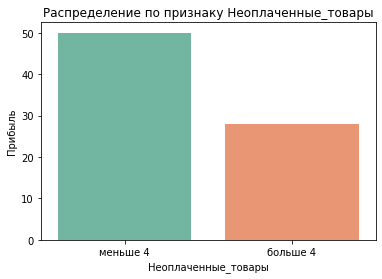

                     Прибыль      Доля
Неоплаченные_товары                   
больше 4              131.39  0.356138
меньше 4              237.54  0.643862


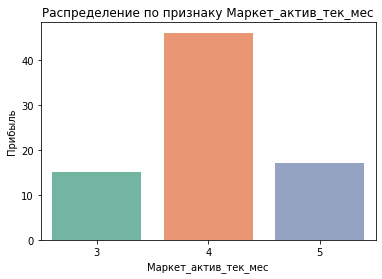

                      Прибыль      Доля
Маркет_актив_тек_мес                   
3                       72.02  0.195213
4                      216.53  0.586914
5                       80.38  0.217873


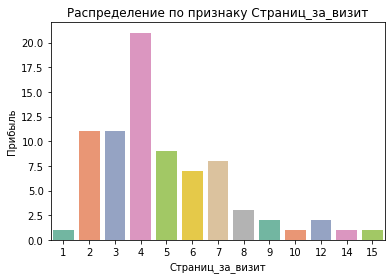

                  Прибыль      Доля
Страниц_за_визит                   
1                    4.17  0.011303
2                   48.73  0.132085
3                   54.40  0.147453
4                   99.84  0.270620
5                   43.88  0.118939
6                   33.75  0.091481
7                   38.03  0.103082
8                   13.90  0.037677
9                    9.01  0.024422
10                   4.98  0.013498
12                   8.30  0.022497
14                   5.13  0.013905
15                   4.81  0.013038


In [ ]:
df['Акционные_покупки_кат'] = df['Акционные_покупки'].apply(lambda x: 'Покупатели по акции' if x > 0.6 else 'Покупатели не только по акции')
df['Вид_поп_категории'] = df['Популярная_категория'].apply(lambda x: 'Товары для себя' if x!='Товары для детей' else 'Товары для детей')
df['Неоплаченные_товары'] = df['Неоплаченные_продукты_штук_квартал'].apply(lambda x: 'больше 4' if x>4 else 'меньше 4')

categories = [
    'Акционные_покупки_кат',
    'Вид_поп_категории',
    'Популярная_категория',
    'Неоплаченные_товары',
    'Маркет_актив_тек_мес',
    'Страниц_за_визит',
]

show_segment(
    categories,
    'Прибыльные покупатели с риском снижения покупательской активности'
)

Сегмент прибыльные покупатели с риском снижения покупательской активности:
- Наблюдается снижение активности на сайте 5-6 страниц за визит, а тааже длительность посещений. Необходимы мероприятия по удержанию клиентов на сайте
- Значительная доля неоплаченных товаров в корзине(35% клиентов имеют более 4 позиций). Необходимы мероприятия по предоставлению скидок на сформрованные позиции в корзине, система уведомления киентов.
- Значительная доля товаров для детей в популяирной категории. Можно предоставить дополнительные скидки на товары для детей.
- Значительная доля покупок по акции. Необходимы мероприятия по накопительным скидкам для долгосрочное сотрудничества с клиентом с данного сегмента.  

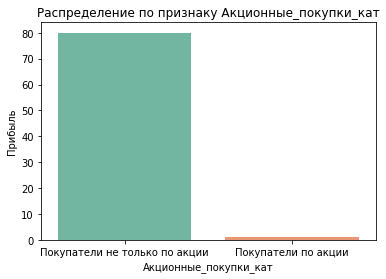

                               Прибыль      Доля
Акционные_покупки_кат                           
Покупатели не только по акции   375.44  0.988729
Покупатели по акции               4.28  0.011271


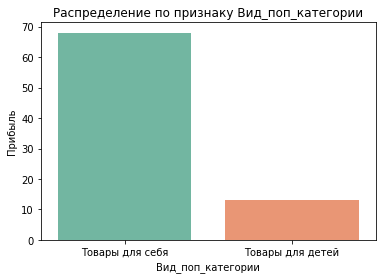

                   Прибыль      Доля
Вид_поп_категории                   
Товары для детей     58.86  0.155009
Товары для себя     320.86  0.844991


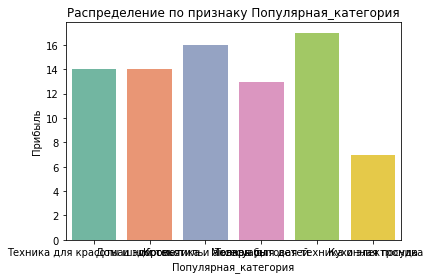

                                      Прибыль      Доля
Популярная_категория                                   
Домашний текстиль                       65.92  0.173602
Косметика и аксесуары                   75.80  0.199621
Кухонная посуда                         31.86  0.083904
Мелкая бытовая техника и электроника    79.67  0.209812
Техника для красоты и здоровья          67.61  0.178052
Товары для детей                        58.86  0.155009


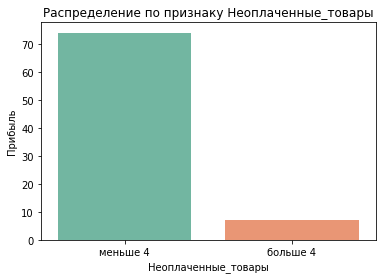

                     Прибыль      Доля
Неоплаченные_товары                   
больше 4               33.81  0.089039
меньше 4              345.91  0.910961


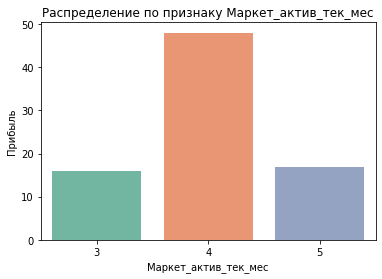

                      Прибыль      Доля
Маркет_актив_тек_мес                   
3                       74.50  0.196197
4                      225.99  0.595149
5                       79.23  0.208654


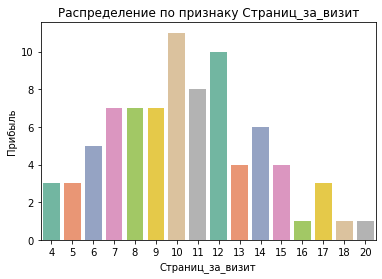

                  Прибыль      Доля
Страниц_за_визит                   
4                   13.38  0.035236
5                   12.84  0.033814
6                   23.50  0.061888
7                   32.74  0.086221
8                   34.85  0.091778
9                   33.43  0.088039
10                  48.83  0.128595
11                  37.93  0.099889
12                  47.98  0.126356
13                  19.56  0.051512
14                  29.10  0.076635
15                  17.72  0.046666
16                   4.46  0.011745
17                  14.74  0.038818
18                   4.36  0.011482
20                   4.30  0.011324


In [ ]:
show_segment(
    categories,
    'Прибыльные покупатели без риска снижения покупательской активности'
)

Сегмент прибыльные покупатели без риска снижения покупательской активности:
- Низкая доля покупок по акции, необходимо повысить маркетиноговое взаимодействие с данным клиентами. Предоставить персональные промо-акции,скидки.

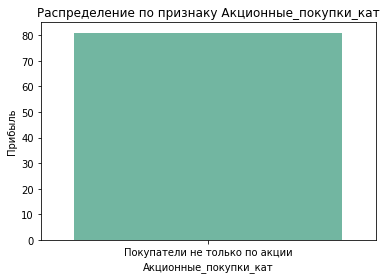

                               Прибыль  Доля
Акционные_покупки_кат                       
Покупатели не только по акции   246.91   1.0


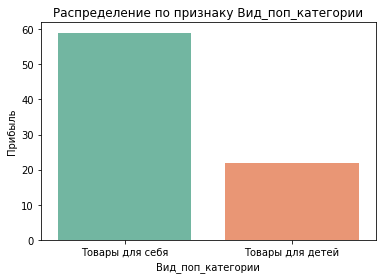

                   Прибыль      Доля
Вид_поп_категории                   
Товары для детей     67.69  0.274148
Товары для себя     179.22  0.725852


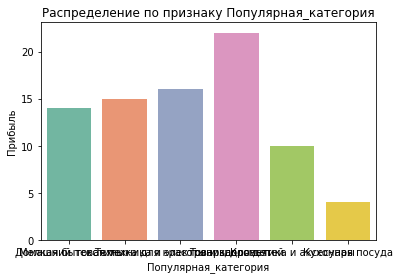

                                      Прибыль      Доля
Популярная_категория                                   
Домашний текстиль                       48.75  0.197440
Косметика и аксесуары                   28.23  0.114333
Кухонная посуда                         14.92  0.060427
Мелкая бытовая техника и электроника    41.26  0.167105
Техника для красоты и здоровья          46.06  0.186546
Товары для детей                        67.69  0.274148


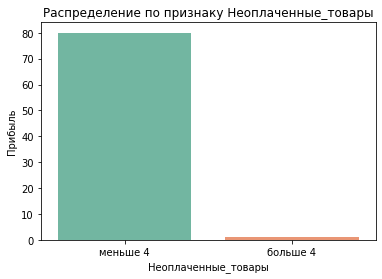

                     Прибыль      Доля
Неоплаченные_товары                   
больше 4                3.09  0.012515
меньше 4              243.82  0.987485


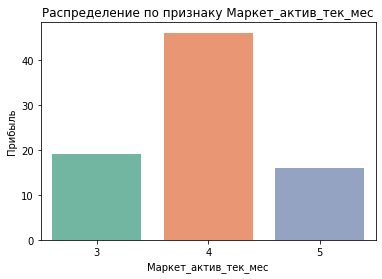

                      Прибыль      Доля
Маркет_актив_тек_мес                   
3                       57.87  0.234377
4                      143.32  0.580454
5                       45.72  0.185169


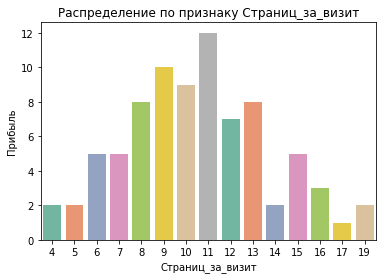

                  Прибыль      Доля
Страниц_за_визит                   
4                    5.45  0.022073
5                    6.57  0.026609
6                   15.83  0.064112
7                   16.16  0.065449
8                   23.95  0.096999
9                   30.32  0.122798
10                  27.47  0.111255
11                  36.37  0.147301
12                  19.85  0.080394
13                  26.17  0.105990
14                   5.26  0.021303
15                  15.95  0.064598
16                   9.98  0.040420
17                   2.59  0.010490
19                   4.99  0.020210


In [ ]:
show_segment(
    categories,
    'Не прибыльные покупатели без риска снижения покупательской активности'
)

Сегмент не прибыльные покупатели без риска снижения покупательской активности:
- Отсутсвие покупок по акции, необходимо повысить маркетиноговое взаимодействие с данным клиентами. Предоставить персональные промо-акции,скидки.

#### Выводы по разделу сегментация акционных покупателей
Выделены 4 сегмента клиентов по вероятности снижения покупательской активности и прибыли от покупатели.


Профиль клиента с высоким риском снижения покупательской активности:
- покупает в основном по акции
- в корзине большое количество неопалченных товаров
- вероятнее всего покупает товары для детей
- поверхностно смотрит ассортимент


- Можно выделить покупателей, которые покупают в большей части товары по акции
- У данных пользователей высокая вероятность снижения покупательской активности, при этом данные покупатели приносят более 10% прибыли, особенно в таких катгориях как Кухонная посуда, Товары для детей, Косметика и аксессуары.  
- Основные признаки предопределяющие снижение покупательской активности - это признаки выявленные в разделе Анализ важности признаков:
  - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца (менее 5 страниц)
  - активность на сайте в предыдущие месяцы (менее 10-15 минут)
  - неоплаченные продкты в корзине более 4 штук

Рекомендации для удержания акционных покупателей:

- Персонализированные предложения. Создать уникальные промо-акции или персонализированные предложения, чтобы удерживать этих клиентов. для повышения их лояльность.

- Упрощение завершения покупок. Уменьшить количество неоплаченных товаров в корзине через напоминания, специальные скидки на незаконченные заказы.

- Повышение вовлеченности. Увеличить время, проведенное на сайте, через рекомендации товаров, систему лояльности или игровые механики для пользователей, чтобы стимулировать более глубокую вовлеченность.

- Оптимизировать сайт для удобного и быстрого просмотра товаров, чтобы пользователи посещали больше страниц.

### Общий вывод

Проект по анализу покупательской активности интернет-магазина продемонстрировал высокую эффективность применения моделей машинного обучения, особенно логистической регрессии (ROC-AUC: 0.86). Были выявлены ключевые факторы, влияющие на снижение покупательской активности, такие как низкая вовлечённость на сайте, большое количество неоплаченных товаров и склонность к акционным покупкам. Сегментация клиентов помогла выделить покупателей с высоким риском снижения активности. Для их удержания предложены меры, включая персонализированные предложения, оптимизацию процесса покупок и стимулирование вовлечённости на сайте.